In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
L = 32
Directory = f"data/L_{L}_new"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [3]:
times = [i for i in range(1,63)]
perm = np.random.permutation(times)
train_times = perm[:int(0.8*len(times))]
test_times = perm[int(0.8*len(times)):]

In [4]:
#init train ds
path_data = Directory+f'/input_ds_for_simple_nn_T{train_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
train_ds = nc_init['sample'][:].filled()

for t in train_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    train_ds = np.concatenate((train_ds, time_ds), axis=0)

In [5]:
#init test ds
path_data = Directory+f'/input_ds_for_simple_nn_T{test_times[0]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()

for t in test_times[1:]:
    path_data = Directory+f'/input_ds_for_simple_nn_T{t}_L_{L}.nc'
    nc_init = nc.Dataset(path_data)
    time_ds = nc_init['sample'][:].filled()
    test_ds = np.concatenate((test_ds, time_ds), axis=0)

In [6]:
# split train and test ds in input-output datasets
input_train, output_train, input_val, output_val = train_ds[:,:len_in], train_ds[:,len_in:], test_ds[:,:len_in], test_ds[:,len_in:]
input_train.shape

(12544, 2256)

## Define the model

In [7]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.1, drop_prob2=0.2, drop_prob3=0.3, hidden_size1=512, hidden_size2=256, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [13]:
learning_rate = 0.001
batch_size = 32
nb_epochs = 50
train_losses=[]
test_losses=[]
n_batches = input_train.shape[0]//batch_size

In [14]:
model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train : convert numpy array to torch tensor
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()

# test : convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

## Train and test the model

In [15]:
# train the model
#model.train()

for epoch in trange(nb_epochs, leave=False):
    model.train()
    tot_losses=0
    indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
    for i_batch in indexes_arr:
        input_batch = input[i_batch,:]
        output_batch = output[i_batch,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss = F.mse_loss(output_pred, output_batch, reduction='sum')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    train_losses.append(tot_losses/n_batches)
    
    model.eval()
    # prediction
    output_pred = model(input_test)
    # compute loss
    test_loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)
    test_losses.append(test_loss)
    
    if (epoch+1)%5==0 or epoch==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/n_batches))

  2%|▏         | 1/50 [00:05<04:10,  5.11s/it]

Epoch [1/50], Loss: 157.241034


 10%|█         | 5/50 [01:09<10:49, 14.43s/it]

Epoch [5/50], Loss: 64.610463


 20%|██        | 10/50 [02:43<12:09, 18.24s/it]

Epoch [10/50], Loss: 47.224255


 30%|███       | 15/50 [04:21<11:17, 19.37s/it]

Epoch [15/50], Loss: 40.696249


 40%|████      | 20/50 [06:00<09:51, 19.73s/it]

Epoch [20/50], Loss: 40.616280


 50%|█████     | 25/50 [07:40<08:18, 19.93s/it]

Epoch [25/50], Loss: 36.787471


 60%|██████    | 30/50 [09:20<06:42, 20.10s/it]

Epoch [30/50], Loss: 39.979255


 80%|████████  | 40/50 [12:40<03:20, 20.02s/it]

Epoch [40/50], Loss: 45.085505


 90%|█████████ | 45/50 [14:22<01:42, 20.49s/it]

Epoch [45/50], Loss: 45.736124


Epoch [50/50], Loss: 52.301600


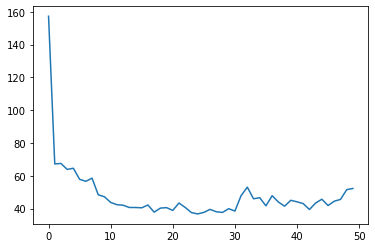

In [17]:
plt.plot(train_losses)

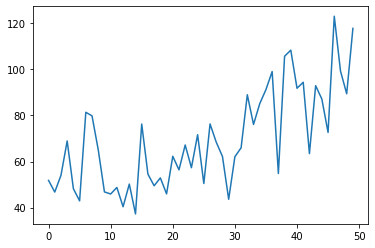

In [18]:
plt.plot(test_losses)

In [19]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 117.709137


In [20]:
torch.save(model.state_dict(), 'explo/simple_dnn')

## Use previous models

In [21]:
model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load('explo/models/simple_dnn5'))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): Linear(in_features=2256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [22]:
# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
tot_losses=0

model_load.eval()
# prediction
output_pred = model_load(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 117.709137


In [23]:
output_test.shape

torch.Size([3328, 376])

Plot the coarse grained heat flux (both predicted and real) from the reconstructed output and objective of the DNN.

t = 33


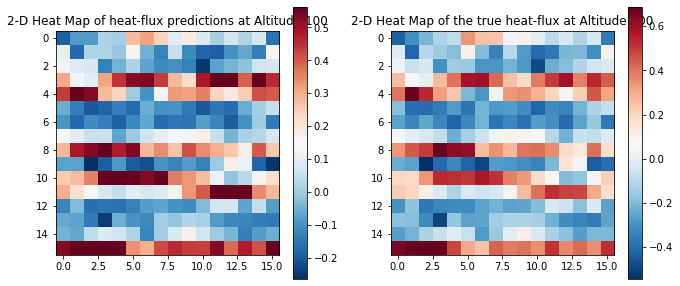

In [24]:
t = 0
z=100
largeur = int(512/L)
pred_ds = output_pred[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()
true_ds = output_test[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()

print('t =',test_times[t])
utils.plot_output(pred_ds,true_ds,L,z,color='RdBu_r')

Plot the coarse grained heat flux from Adrien's written nc files.

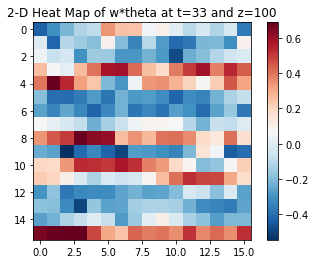

In [25]:
path_data = f'data/L_{L}_new/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()[:,-(376-z)].reshape(16,16)
im = plt.imshow(test_ds , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()

## Check coherence

Plot the coarse grained heat flux directly from Sara's high res simulation

In [29]:
nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/wxy{z//2}_T{test_times[t]}.nc")
w_arr = nc_init[f'wxy{z//2}'][:].filled()[0,1,:,:]

nc_init = nc.Dataset(f"/glade/scratch/sshamekh/LES_512_ug16wtspt01_data/thetaxy{z//2}_T{test_times[t]}.nc")
theta_arr = nc_init[f'thetaxy{z//2}'][:].filled()[0,1,:,:]

wtheta = w_arr*theta_arr

fig,axes = plt.subplots(1,2,figsize=(13,5))

im0 = axes[0].imshow(wtheta , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")

im1 = axes[1].imshow(utils.coarse_array(wtheta.reshape(1,1,512,512),L).reshape(16,16) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D coarse grained Heat Map of w*theta at t={test_times[t]} and z={z}")

plt.show()

NameError: name 'test_times' is not defined

## Define baseline model

Baseline model : $\overline{w*theta} \simeq \overline{w}*\overline{theta}$

Comparison of objective heat flux, baseline heat flux and element wise difference of them.

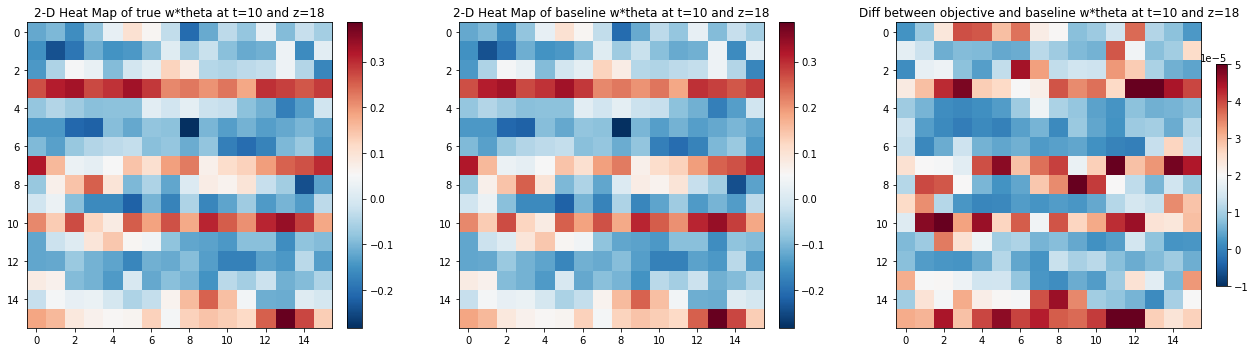

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

z=0     # equivalent to z=18 : first alt is 18
path_data = 'data/L_32/input_ds_for_simple_nn_T10_L_32.nc'  #'data/L_32_new/input_ds_for_simple_nn_T10_L_32.nc'
nc_init = nc.Dataset(path_data)
true_heat_flux = nc_init[f'sample'][:].filled()[:,-(4-z)].reshape(16,16)        #-(4-z) because : last 4 are wtheta, -(4-z) is wtheta at alt z

w_arr = nc_init[f'sample'][:].filled()[:,-(16-z)].reshape(16,16)
theta_arr = nc_init[f'sample'][:].filled()[:,-(12-z)].reshape(16,16)
baseline_heat_flux = w_arr*theta_arr

fig,axes = plt.subplots(1,3,figsize=(18,5))

im0 = axes[0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of true w*theta at t={10} and z={18}")

im1 = axes[1].imshow(baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D Heat Map of baseline w*theta at t={10} and z={18}")

im2 = axes[2].imshow(true_heat_flux - baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' , vmin=-0.00001 , vmax = 0.00005)
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.03, pad=0.04)
axes[2].set_title(f"Diff between objective and baseline w*theta at t={10} and z={18}")

fig.tight_layout()
plt.show()

Problem : the baseline seems to be way closer to the objective than NN.

-> problem is in the computation of training data ?

## Compare model and baseline

baseline loss

In [16]:
loss = 0
for i in range(16):
    for j in range(16):
        loss += (true_heat_flux[i,j] - baseline_heat_flux[i,j])**2
loss

1.4567439904702952e-07